In [1]:
import pandas as pd
import kagglehub

path = kagglehub.dataset_download("radheshyamkollipara/bank-customer-churn")

print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/Customer-Churn-Records.csv")
# Because 'Complain' column is identical to 'Exited' column (Dataset mistake)
df.drop(['Complain'], axis=1, inplace=True)

Path to dataset files: C:\Users\Dmytro\.cache\kagglehub\datasets\radheshyamkollipara\bank-customer-churn\versions\1


In [2]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [3]:
df.isna().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [4]:
df.dtypes

RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>],
       [<Axes: title={'center': 'Satisfaction Score'}>,
        <Axes: title={'center': 'Point Earned'}>, <Axes: >]], dtype=object)

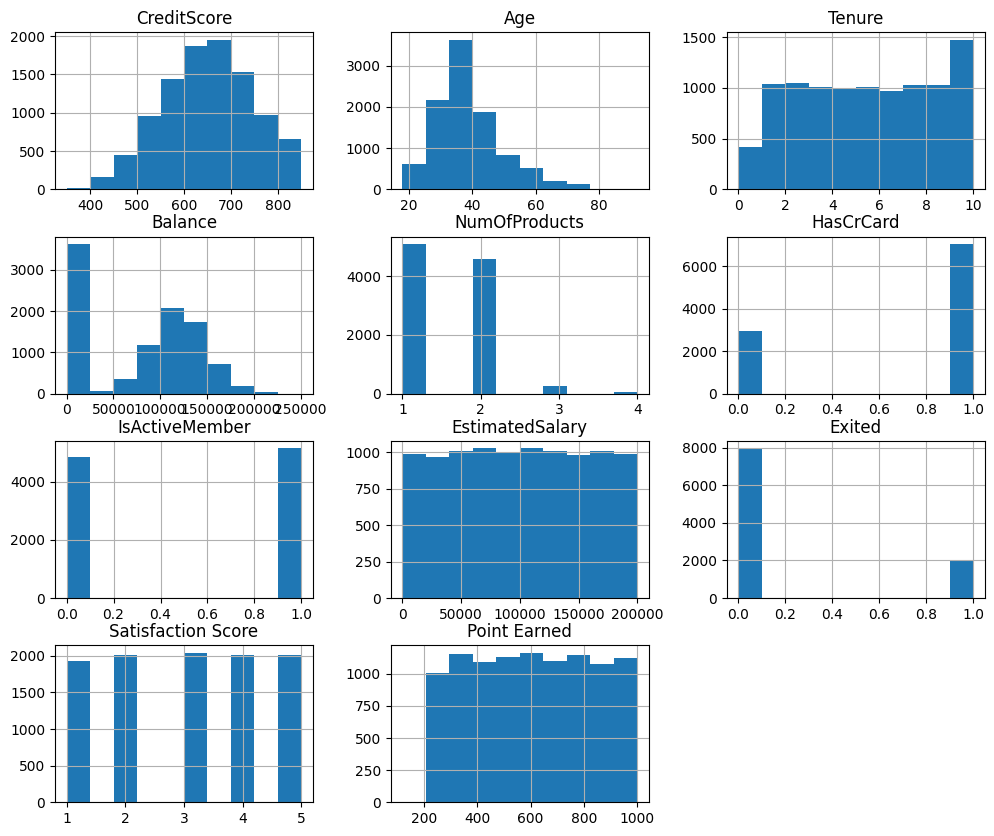

In [5]:
df.drop(["RowNumber", "CustomerId"], axis=1).hist(figsize=(12,10))

<Axes: >

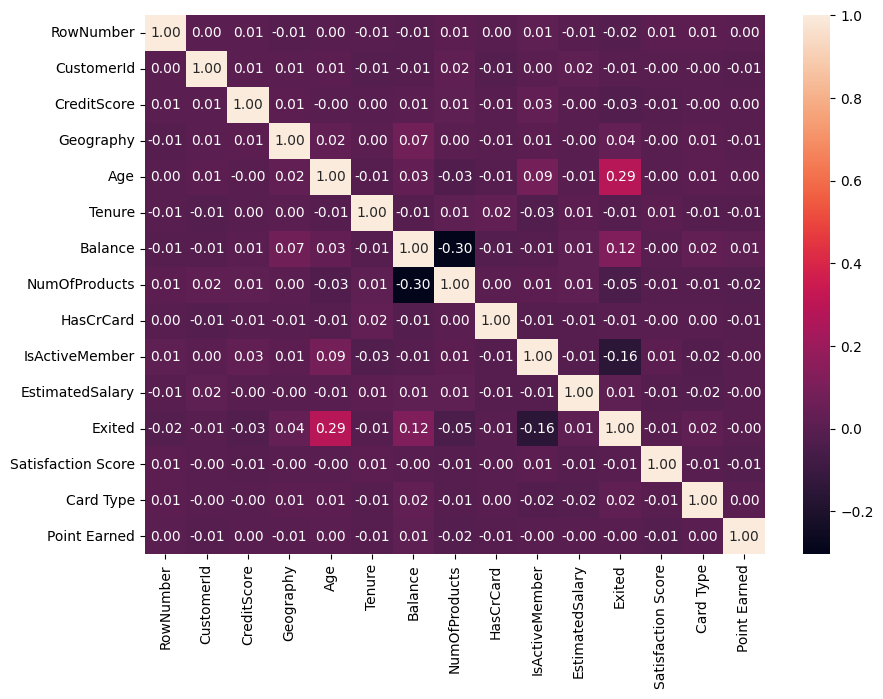

In [7]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
data = df.drop(["Surname", "Gender"], axis=1)
le_geo = LabelEncoder()
df['Geography'] = le_geo.fit_transform(df['Geography'])
df['Card Type'] = df['Card Type'].replace({'SILVER':0,'GOLD':1,'PLATINUM':2,'DIAMOND':3})
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(), annot=True, fmt=".2f")

In [ ]:
df['Exited'].value_counts()

Exited
0    7962
1    2038
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

df = df.rename(columns={"Point Earned": "PointEarned", "Satisfaction Score": "SatisfactionScore", "Card Type": "CardType"})
data = df.drop(["Surname", "Gender", "RowNumber", "CustomerId"], axis=1)
X = data.drop("Exited", axis=1)
y = data["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = ['Geography', 'CardType']
num_cols = [col for col in X.columns if col not in cat_cols]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ])

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, scale_pos_weight=scale_pos_weight)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
joblib.dump(pipeline, "bank_churn.joblib")

Confusion Matrix:
 [[1316  291]
 [  87  306]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87      1607
           1       0.51      0.78      0.62       393

    accuracy                           0.81      2000
   macro avg       0.73      0.80      0.75      2000
weighted avg       0.85      0.81      0.82      2000



['bank_churn.joblib']